In [9]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from pycaret.clustering import ClusteringExperiment

In [2]:
df = pd.read_parquet('data/combined_timeseries_interpolated.parquet')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1644000 entries, 0 to 1643999
Data columns (total 52 columns):
 #   Column                    Non-Null Count    Dtype         
---  ------                    --------------    -----         
 0   fips                      1644000 non-null  int64         
 1   date                      1644000 non-null  datetime64[ns]
 2   PRECTOT                   1644000 non-null  float64       
 3   PS                        1644000 non-null  float64       
 4   QV2M                      1644000 non-null  float64       
 5   T2M                       1644000 non-null  float64       
 6   T2MDEW                    1644000 non-null  float64       
 7   T2MWET                    1644000 non-null  float64       
 8   T2M_MAX                   1644000 non-null  float64       
 9   T2M_MIN                   1644000 non-null  float64       
 10  T2M_RANGE                 1644000 non-null  float64       
 11  TS                        1644000 non-null  float6

In [4]:
len(df.fips.unique())

500

In [5]:
# Haremos clusters solo usando las variables meteorológicas: QV2M, WS10M, T2M, WS50M, TS, PS, T2MDEW, T2MWET, PRECTOT, elevation.
# Creamos el subset de datos con estas variables.
df_meteo = df[['QV2M', 'WS10M', 'T2M', 'WS50M', 'TS', 'PS', 'T2MDEW', 'T2MWET', 'PRECTOT', 'elevation']]

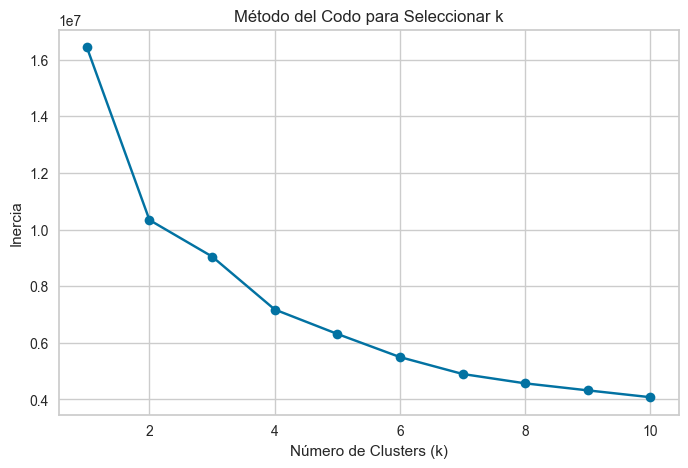

In [6]:
X = df_meteo

# Estandarización de los datos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Determinar el número óptimo de clusters usando el método del codo
inertia = []
range_k = range(1, 11)
for k in range_k:
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

# Graficar el método del codo
plt.figure(figsize=(8, 5))
plt.plot(range_k, inertia, marker='o')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Inercia')
plt.title('Método del Codo para Seleccionar k')
plt.show()

Inicializar KMeans y ajustar
Calcular el promedio de la silueta


KeyboardInterrupt: 

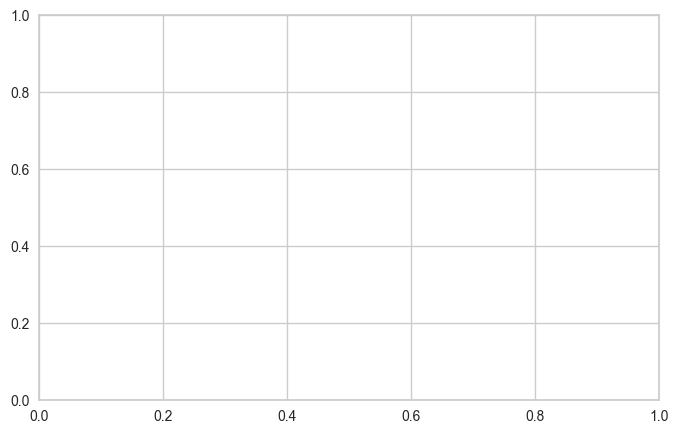

In [7]:
# Crear un gráfico de la silueta para un rango de valores k
range_k = range(2, 6)  # Empezando desde 2 porque la silueta no tiene sentido para k=1

for k in range_k:
    print('Inicializando con k =', k)
    fig, ax = plt.subplots(1, 1)
    fig.set_size_inches(8, 5)

    print('Inicializar KMeans y ajustar')
    kmeans = KMeans(n_clusters=k, random_state=0)
    cluster_labels = kmeans.fit_predict(X_scaled)

    print('Calcular el promedio de la silueta')
    silhouette_avg = silhouette_score(X_scaled, cluster_labels)
    print(f'Para k = {k}, el promedio de la silueta es: {silhouette_avg:.4f}')

    print('Calcular los coeficientes de silueta para cada punto')
    sample_silhouette_values = silhouette_samples(X_scaled, cluster_labels)

    y_lower = 10
    for i in range(k):
        # Agrega los coeficientes de silueta de los clusters
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / k)
        ax.fill_betweenx(np.arange(y_lower, y_upper),
                         0, ith_cluster_silhouette_values,
                         facecolor=color, edgecolor=color, alpha=0.7)

        # Etiqueta en el gráfico
        ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        y_lower = y_upper + 10  # Añadir espacio entre clusters

    ax.set_title(f'Gráfico de la Silueta para k = {k}')
    ax.set_xlabel('Coeficiente de Silueta')
    ax.set_ylabel('Etiqueta del Cluster')

    # Línea vertical para el promedio de la silueta
    ax.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax.set_yticks([])  # No etiquetas en el eje y
    ax.set_xticks(np.arange(-0.1, 1.1, 0.2))

    plt.show()

In [10]:
# Normalizar las variables meteorológicas usando StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_meteo)

# Aplicar DBSCAN (ajustando los hiperparámetros eps y min_samples según sea necesario)
dbscan = DBSCAN(eps=0.5, min_samples=5)  # Puedes ajustar los valores de eps y min_samples
clusters = dbscan.fit_predict(X_scaled)

# Añadir los clusters como una nueva columna en el DataFrame original
df_meteo['cluster'] = clusters

# Verificar la cantidad de clusters
print(f"Número de clusters encontrados: {len(set(clusters)) - (1 if -1 in clusters else 0)}")
print(f"Número de puntos etiquetados como ruido: {list(clusters).count(-1)}")

# Graficar los clusters si tienes dos variables meteorológicas en df_meteo
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=clusters, cmap='viridis', marker='o')
plt.title('Clusters con DBSCAN')
plt.xlabel('Variable 1 (normalizada)')
plt.ylabel('Variable 2 (normalizada)')
plt.show()